In [ ]:
! pip install pydantic
! pip install PyYAML
! pip install numpy==1.26.4
! pip install torch==2.1.2 torchvision==0.16.2 torchaudio==2.1.2
! pip install --no-cache-dir dgl -f https://data.dgl.ai/wheels/repo.html
! pip install dill
! pip install torchdata==0.6.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 83.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 70.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.

In [ ]:
import pandas as pd
import torch
import dgl.sparse as dglsp
import torch
import torch.nn as nn
import torch.nn.functional as F
import random

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [ ]:
df=pd.read_excel('/content/drive/MyDrive/Graph_Research/filtered_dataset.xlsx')

In [ ]:
df['concept'] = df['concept'].astype(str)
df['paper_id'] = df['paper_id'].astype(str)

In [ ]:
datadir = '/content/drive/MyDrive/Graph_Research'
max_groupsize = 169
import pickle

# Load the vertex embeddings from the file
with open(datadir + '/vertex_embeddings3_' + str(max_groupsize) + '.p', 'rb') as fp:
    vertex_data = pickle.load(fp)
node_ids = vertex_data["ids"]
node_embeddings = vertex_data["embeddings"]

In [ ]:
with open(datadir + '/hyperedge_embeddings3_' + str(max_groupsize) + '.p', 'rb') as fp:
    hyperedge_data = pickle.load(fp)
hyperedge_ids=hyperedge_data["ids"]
hyperedge_embeddings=hyperedge_data["embeddings"]

In [ ]:
def create_incidence_matrix(df):
  concept_to_idx={word:node_ids.index(word) for word in list(df['concept'].unique())}
  paper_to_idx={str(paper_id):hyperedge_ids.index(paper_id) for paper_id in list(df['paper_id'].unique())}

  rows=[]
  cols=[]
  for _, row in df.iterrows():
    concept_idx=concept_to_idx[row['concept']]
    paper_idx=paper_to_idx[row['paper_id']]
    rows.append(concept_idx)
    cols.append(paper_idx)
  rows=torch.tensor(rows)
  cols=torch.tensor(cols)

  H=dglsp.spmatrix(torch.stack([rows,cols]))
  return H, concept_to_idx

H, concept_to_idx_train = create_incidence_matrix(df)

In [ ]:
H.to_dense()

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])

In [ ]:
def generate_positive_samples(df, max_len=16):
    """Generates positive samples (keyword sets that form real hyperedges) from the dataframe."""
    positive_samples = df.groupby('paper_id')['concept'].apply(list).tolist()

    positive_samples_indices = [[node_ids.index(word) if word in node_ids else -1 for word in sublist] for sublist in positive_samples]
    positive_samples_indices = [[word_index for word_index in sample if word_index != -1] for sample in positive_samples_indices]

    #Pad or truncate to ensure consistent length
    padded_samples = []
    for sample in positive_samples_indices:
        if len(sample) < max_len:
            # Pad with zeros
            padded_samples.append(sample + [-1] * (max_len - len(sample))) # Padding with zeros
        elif len(sample) > max_len:
            # Truncate
            padded_samples.append(sample[:max_len])
        else:
            padded_samples.append(sample)

    return torch.tensor(padded_samples, dtype=torch.long)

In [ ]:
def generate_negative_samples(df, num_samples, max_len=16):

    negative_samples = []
    positive_samples_list = [list(row) for row in df.groupby('paper_id')['concept'].apply(list).tolist()]  # Positive samples as list of lists

    while len(negative_samples) < num_samples:
        # Randomly select a set of keywords and ensure it’s not in positive_samples
        neg_sample_concepts = random.sample(node_ids, random.randint(10,16))
        if neg_sample_concepts not in positive_samples_list:
            # Convert concepts to their indices
            neg_sample_indices = [node_ids.index(word) for word in neg_sample_concepts]

            # Pad or truncate to max_len
            if len(neg_sample_indices) < max_len:
                # Pad with zeros
                neg_sample_indices += [-1] * (max_len - len(neg_sample_indices))
            elif len(neg_sample_indices) > max_len:
                # Truncate to max_len
                neg_sample_indices = neg_sample_indices[:max_len]

            negative_samples.append(neg_sample_indices)

    return torch.tensor(negative_samples, dtype=torch.long)

In [ ]:
from sklearn.model_selection import train_test_split

# Generate positive and negative samples
positive_samples = generate_positive_samples(df, max_len=16)
negative_samples = generate_negative_samples(df, num_samples=len(positive_samples), max_len=16)

# Create labels
positive_labels = torch.ones(len(positive_samples), dtype=torch.long)  # Label 1 for positive samples
negative_labels = torch.zeros(len(negative_samples), dtype=torch.long)  # Label 0 for negative samples

# Combine samples and labels
all_samples = torch.cat([positive_samples, negative_samples], dim=0)
all_labels = torch.cat([positive_labels, negative_labels], dim=0)

# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(all_samples, all_labels, test_size=0.3, random_state=42, stratify=all_labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Print dataset sizes
print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")


Training set: 10677 samples
Validation set: 2288 samples
Test set: 2289 samples


In [ ]:
X_train

tensor([[ 271,  376, 4903,  ...,   -1,   -1,   -1],
        [1511,  209, 2049,  ...,   34, 2164, 2013],
        [ 693,    4,   61,  ...,  966, 2904,  215],
        ...,
        [ 260,  301, 3703,  ...,  423,  693,  151],
        [1011, 3109, 1507,  ...,   -1,   -1,   -1],
        [ 100,  571,   21,  ...,   20,   16,    0]])

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class HyperSAGE(nn.Module):
    def __init__(self, node_dim, edge_dim, hidden_dim, out_dim, num_layers=1):

        super(HyperSAGE, self).__init__()
        self.num_layers = num_layers
        self.node_to_edge_mlp = nn.ModuleList([
            nn.Linear(node_dim if i == 0 else hidden_dim, hidden_dim) for i in range(num_layers)
        ])
        self.dropout = nn.Dropout(0.2)
        # self.edge_to_node_mlp = nn.ModuleList([
        #     nn.Linear(edge_dim if i == 0 else hidden_dim, hidden_dim) for i in range(num_layers)
        # ])
        # Change in edge_to_node_mlp input dimension from edge_dim to hidden_dim
        self.edge_to_node_mlp = nn.ModuleList([
            nn.Linear(hidden_dim, hidden_dim) for i in range(num_layers) # Change from edge_dim to hidden_dim
        ])
        self.output_layer = nn.Linear(hidden_dim, hidden_dim)
        self.scoring_layer=nn.Linear(hidden_dim,1)

    def forward(self, node_embeddings, edge_embeddings, incidence_matrix, candidate_hyperedges):

        for i in range(self.num_layers):
            # Node to hyperedge aggregation

            edge_inputs = torch.matmul(incidence_matrix.T, node_embeddings)  # Aggregate node embeddings to edges
            edge_embeddings = F.relu(self.node_to_edge_mlp[i](edge_inputs))

            # Hyperedge to node aggregation
            node_inputs = torch.matmul(incidence_matrix, edge_embeddings)  # Aggregate edge embeddings to nodes
            node_embeddings = F.relu(self.edge_to_node_mlp[i](node_inputs))

        # Final layer for node embeddings
        final_node_embeddings=self.output_layer(node_embeddings)

        # Gather embeddings for each candidate hyperedge
        candidate_node_embeddings = final_node_embeddings[candidate_hyperedges]  # Shape: [num_hyperedges, max_len, embedding_dim]

        # Calculate mean embeddings for each hyperedge
        hyperedge_embs = candidate_node_embeddings.mean(dim=1)  # Mean across nodes in each hyperedge

        # Score candidate hyperedges
        scores = self.scoring_layer(hyperedge_embs).squeeze(dim=-1)
        scores = scores.sigmoid()  # Convert to probabilities between 0 and 1

        return scores


# Example usage
num_nodes = node_embeddings.shape[0]
num_edges = hyperedge_embeddings.shape[0]
node_dim = 16
edge_dim = 50
hidden_dim = 32
out_dim = 32

H_dense=H.to_dense()
hyperedge_embeddings=torch.tensor(hyperedge_embeddings, dtype=torch.float32)
node_embeddings=torch.tensor(node_embeddings, dtype=torch.float32)

model = HyperSAGE(node_dim, edge_dim, hidden_dim, out_dim)
# output = model(node_embeddings, hyperedge_embeddings, H_dense)
# print("Hyper-SAGE Output Shape:", output.shape)

In [ ]:
import torch.optim as optim
learning_rate = 0.001
num_epochs = 100

# Initialize model, loss, and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses=[]
val_losses=[]

# Training and Validation Loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    optimizer.zero_grad()
    predictions = model(node_embeddings, hyperedge_embeddings, H_dense, X_train)  # Forward pass
    train_loss = criterion(predictions, y_train.float())  # Compute loss
    train_loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Validation phase
    model.eval()
    with torch.no_grad():
        val_predictions = model(node_embeddings, hyperedge_embeddings, H_dense, X_val)
        val_loss = criterion(val_predictions, y_val.float())
        val_accuracy = ((val_predictions >= 0.5) == y_val).float().mean().item()
    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())

    # Print epoch results
    print(
        f"Epoch {epoch+1}/{num_epochs}, "
        f"Train Loss: {train_loss.item():.4f}, "
        f"Val Loss: {val_loss.item():.4f}, "
        f"Val Accuracy: {val_accuracy:.4f}"
    )

Epoch 1/100, Train Loss: 0.3607, Val Loss: 0.6312, Val Accuracy: 0.6416
Epoch 2/100, Train Loss: 0.6297, Val Loss: 0.3584, Val Accuracy: 0.8514
Epoch 3/100, Train Loss: 0.3576, Val Loss: 1.1260, Val Accuracy: 0.5909
Epoch 4/100, Train Loss: 1.1149, Val Loss: 0.3709, Val Accuracy: 0.8785
Epoch 5/100, Train Loss: 0.3710, Val Loss: 0.4123, Val Accuracy: 0.7841
Epoch 6/100, Train Loss: 0.4106, Val Loss: 0.5433, Val Accuracy: 0.6875
Epoch 7/100, Train Loss: 0.5414, Val Loss: 0.6391, Val Accuracy: 0.6429
Epoch 8/100, Train Loss: 0.6371, Val Loss: 0.6821, Val Accuracy: 0.6285
Epoch 9/100, Train Loss: 0.6798, Val Loss: 0.6750, Val Accuracy: 0.6307
Epoch 10/100, Train Loss: 0.6723, Val Loss: 0.6273, Val Accuracy: 0.6508
Epoch 11/100, Train Loss: 0.6240, Val Loss: 0.5519, Val Accuracy: 0.6879
Epoch 12/100, Train Loss: 0.5477, Val Loss: 0.4660, Val Accuracy: 0.7434
Epoch 13/100, Train Loss: 0.4601, Val Loss: 0.3939, Val Accuracy: 0.8108
Epoch 14/100, Train Loss: 0.3858, Val Loss: 0.3772, Val Accu

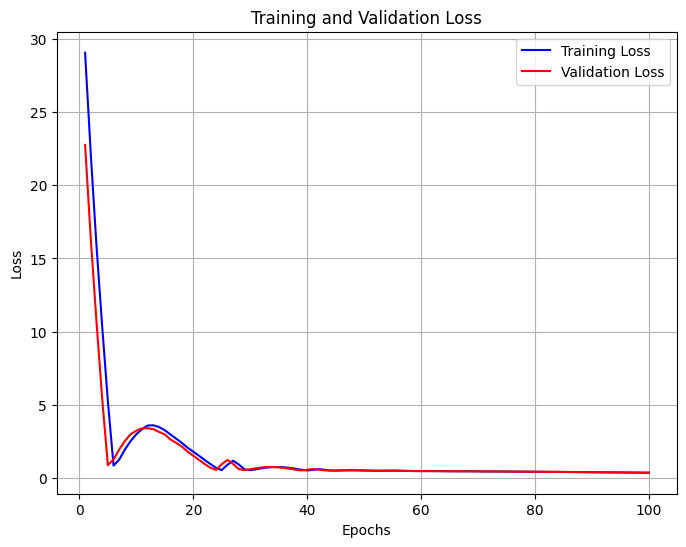

In [ ]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss", color='blue', linestyle='-')
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss", color='red', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()



Test Results:
Accuracy: 0.8484
Precision: 0.8049
Recall: 0.9196
F1 Score: 0.8584

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.78      0.84      1145
           1       0.80      0.92      0.86      1144

    accuracy                           0.85      2289
   macro avg       0.86      0.85      0.85      2289
weighted avg       0.86      0.85      0.85      2289



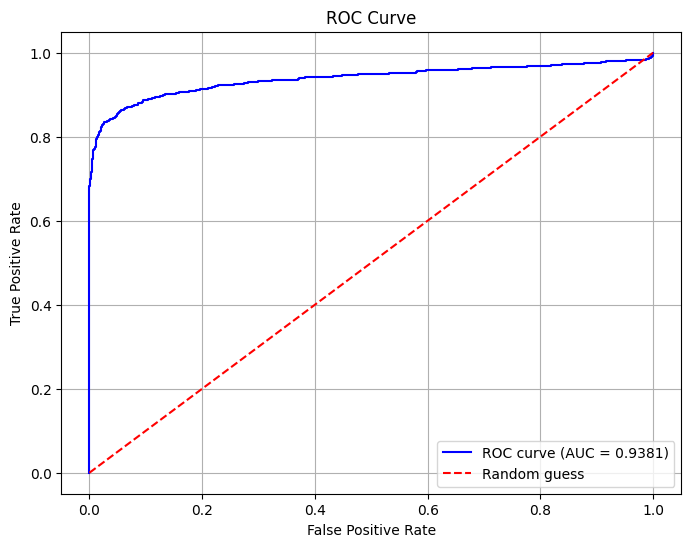

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt

# After training loop
model.eval()
with torch.no_grad():
    # Get test predictions
    test_predictions = model(node_embeddings, hyperedge_embeddings, H_dense, X_test)
    test_predictions_labels = (test_predictions >= 0.5).long()  # Convert probabilities to binary labels

    # Calculate metrics
    accuracy = accuracy_score(y_test.cpu(), test_predictions_labels.cpu())
    precision = precision_score(y_test.cpu(), test_predictions_labels.cpu())
    recall = recall_score(y_test.cpu(), test_predictions_labels.cpu())
    f1 = f1_score(y_test.cpu(), test_predictions_labels.cpu())
    report = classification_report(y_test.cpu(), test_predictions_labels.cpu())

    print("\nTest Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\nClassification Report:\n", report)

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test.cpu(), test_predictions.cpu())
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color="blue", label=f"ROC curve (AUC = {roc_auc:.4f})")
    plt.plot([0, 1], [0, 1], color="red", linestyle="--", label="Random guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()


In [ ]:
# Test phase
model.eval()
with torch.no_grad():
    test_predictions = model(node_embeddings, hyperedge_embeddings, H_dense, X_test)
    test_loss = criterion(test_predictions, y_test.float())
    test_accuracy = ((test_predictions >= 0.5) == y_test).float().mean().item()

# Print test results
print(
    f"Test Loss: {test_loss.item():.4f}, "
    f"Test Accuracy: {test_accuracy:.4f}"
)


Test Loss: 0.3489, Test Accuracy: 0.8851


Test Loss: 0.3489


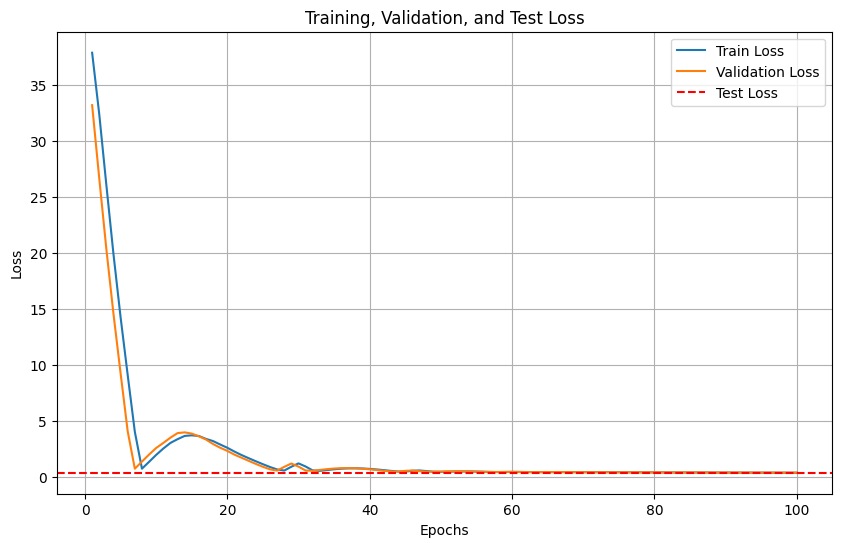

In [ ]:
import matplotlib.pyplot as plt
print(f"Test Loss: {test_loss:.4f}")

# Plot the loss curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')  # Test loss as a horizontal line
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training, Validation, and Test Loss')
plt.legend()
plt.grid()
plt.show()